In [2]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd

In [4]:
# 1. 데이터 로드
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample2.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample2.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample2.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample2.csv')

In [5]:
len(df_y_train)

246

In [6]:
X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)  # 1차원 배열(벡터)로 변환
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)  # 1차원 배열(벡터)로 변환

In [7]:
# 소수 클래스와 다수 클래스 식별
target_counts = pd.Series(y_train).value_counts()
minority_class = target_counts.idxmin()
majority_class = target_counts.idxmax()

# 소수 클래스 샘플 추출
X_minority = X_train[y_train == minority_class]
X_major = X_train[y_train == majority_class]

In [8]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.6 MB/s eta 0:00:00


In [9]:
from dtaidistance import dtw
from scipy.spatial.distance import euclidean
import random
from tqdm import tqdm
from dtaidistance.dtw import distance  # 함수 이름은 distance임

In [10]:
from dtaidistance.dtw import distance as dtw_distance  # 함수 이름을 바꿔서 import

def calculate_all_dtw_distances(X):
    distances = []
    n = len(X)
    for i in range(n):
        for j in range(i + 1, n):
            dist_val = dtw_distance(X[i], X[j])  # 함수 호출
            distances.append((i, j, dist_val))   # 결과 저장
    return distances


In [11]:
# DTW 거리 계산 실행
X_all = np.vstack((X_minority, X_major))  # 전체 학습 데이터
y_all = np.hstack((np.full(len(X_minority), minority_class), np.full(len(X_major), majority_class)))

print(f"전체 샘플 수: {len(X_all)}, 소수 클래스: {minority_class}, 다수 클래스: {majority_class}")

# 모든 샘플 간의 DTW 거리 계산
dtw_distances = calculate_all_dtw_distances(X_all)

# 거리 행렬 초기화
n_samples = len(X_all)
dtw_matrix = np.zeros((n_samples, n_samples))

# 거리 행렬 채우기
for i, j, dist_val in dtw_distances:
    dtw_matrix[i, j] = dist_val
    dtw_matrix[j, i] = dist_val  # 대칭 행렬

print("DTW 거리 행렬 계산 완료:", dtw_matrix.shape)


전체 샘플 수: 246, 소수 클래스: 0, 다수 클래스: 1
DTW 거리 행렬 계산 완료: (246, 246)


In [13]:
k = 3  # 홀수로 설정 (예: 3, 5, 7 등)

safe_minority_indices = []  # 안전 샘플 인덱스
risky_minority_indices = []  # 위험 샘플 인덱스

minority_indices = np.where(y_all == minority_class)[0]
majority_indices = np.where(y_all == majority_class)[0]

for idx in minority_indices:
    distances = dtw_matrix[idx]

    # 자기 자신 제외하고 가까운 이웃 k개 선택
    nearest_indices = np.argsort(distances)[1:k+1]

    # 이웃의 클래스 확인
    neighbor_labels = y_all[nearest_indices]
    minority_count = np.sum(neighbor_labels == minority_class)
    majority_count = np.sum(neighbor_labels == majority_class)

    # 안전 / 위험 분류
    if minority_count < majority_count:
        safe_minority_indices.append(idx)
    else:
        risky_minority_indices.append(idx)

print(f"총 소수 클래스 수: {len(minority_indices)}")
print(f"안전 샘플 수: {len(safe_minority_indices)}")
print(f"위험 샘플 수: {len(risky_minority_indices)}")


총 소수 클래스 수: 12
안전 샘플 수: 11
위험 샘플 수: 1


In [14]:
# 증강할 데이터 수
n_augment = len(X_major) - len(X_minority)  # 다수 - 소수
n_safe = len(safe_minority_indices)

# 한 쌍에서 생성해야 할 수
n_per_pair = n_augment // n_safe
remainder = n_augment % n_safe

print(f"총 생성할 샘플 수: {n_augment} (각 쌍당 {n_per_pair}개, 남는 수 {remainder})")


총 생성할 샘플 수: 222 (각 쌍당 20개, 남는 수 2)


In [15]:

augmented_data = []
random.seed(42)

# 안전 샘플 쌍 조합을 만들고 증강
for i, idx in enumerate(safe_minority_indices):
    for _ in range(n_per_pair):
        # 다른 안전 샘플 하나 무작위 선택
        other_idx = random.choice([j for j in safe_minority_indices if j != idx])

        # 선형 보간 (alpha: 0~1 사이 랜덤)
        alpha = np.random.rand()
        new_sample = alpha * X_all[idx] + (1 - alpha) * X_all[other_idx]
        augmented_data.append(new_sample)

# 남는 remainder 개수도 랜덤하게 더 생성
for _ in range(remainder):
    idx1, idx2 = random.sample(safe_minority_indices, 2)
    alpha = np.random.rand()
    new_sample = alpha * X_all[idx1] + (1 - alpha) * X_all[idx2]
    augmented_data.append(new_sample)

# 최종 증강 데이터와 레이블 결합
X_aug = np.array(augmented_data)
y_aug = np.full(len(X_aug), minority_class)

# 기존 학습 데이터와 결합
X_train_balanced = np.vstack((X_all, X_aug))
y_train_balanced = np.hstack((y_all, y_aug))

print("증강 완료!")
print(f"최종 데이터 크기: {X_train_balanced.shape}, 레이블 분포: {pd.Series(y_train_balanced).value_counts().to_dict()}")


증강 완료!
최종 데이터 크기: (468, 80), 레이블 분포: {0: 234, 1: 234}


In [16]:
# 교차 검증을 위한 설정
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Flatten
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# balanced된 데이터셋 사용하도록 변수 설정
X_synthetic = X_train_balanced
y_synthetic = y_train_balanced

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
best_threshold = None
best_specificity = 0
best_model = None

for fold, (train_index, val_index) in enumerate(skf.split(X_synthetic, y_synthetic)):
    print(f"Fold {fold+1}")

    X_train_fold, X_val_fold = X_synthetic[train_index], X_synthetic[val_index]
    y_train_fold, y_val_fold = y_synthetic[train_index], y_synthetic[val_index]

    rf_model.fit(X_train_fold, y_train_fold)
    y_pred_proba = rf_model.predict_proba(X_val_fold)[:, 1]

    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        y_pred_temp = (y_pred_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred_temp).ravel()
        specificity = tn / (tn + fp)
        if specificity > best_specificity:
            best_specificity = specificity
            best_threshold = threshold
            best_model = rf_model

print(f"Best Threshold: {best_threshold}")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Best Threshold: 0.25252525252525254


In [18]:

# 최적 모델로 테스트 예측
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

In [19]:
# 예측 함수들 정의
def predict_with_best_rf(X_test):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    return (y_pred_proba >= best_threshold).astype(int)

def predict_with_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_cart(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_knn(X_train, y_train, X_test, k=3):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_xgboost(X_train, y_train, X_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_lstm(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

def predict_with_cnn(X_train, y_train, X_test):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:50:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(*

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Logistic Regression 모델 성능:
정확도: 0.6471, F1: 0.7656, Recall: 0.9074, Precision: 0.6622, Specificity: 0.1935
Confusion Matrix:
[[ 6 25]
 [ 5 49]]


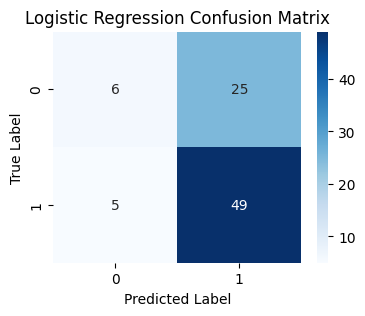

CART 모델 성능:
정확도: 0.6235, F1: 0.7647, Recall: 0.9630, Precision: 0.6341, Specificity: 0.0323
Confusion Matrix:
[[ 1 30]
 [ 2 52]]


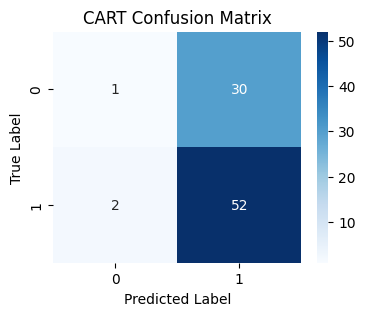

KNN 모델 성능:
정확도: 0.6941, F1: 0.7759, Recall: 0.8333, Precision: 0.7258, Specificity: 0.4516
Confusion Matrix:
[[14 17]
 [ 9 45]]


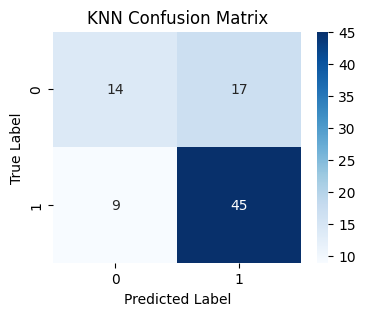

XGBoost 모델 성능:
정확도: 0.6235, F1: 0.7576, Recall: 0.9259, Precision: 0.6410, Specificity: 0.0968
Confusion Matrix:
[[ 3 28]
 [ 4 50]]


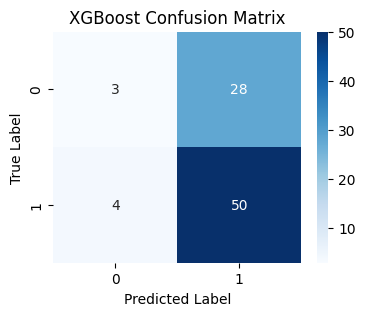

LSTM 모델 성능:
정확도: 0.4941, F1: 0.3385, Recall: 0.2037, Precision: 1.0000, Specificity: 1.0000
Confusion Matrix:
[[31  0]
 [43 11]]


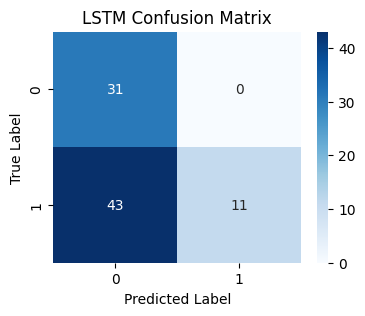

CNN 모델 성능:
정확도: 0.6706, F1: 0.7846, Recall: 0.9444, Precision: 0.6711, Specificity: 0.1935
Confusion Matrix:
[[ 6 25]
 [ 3 51]]


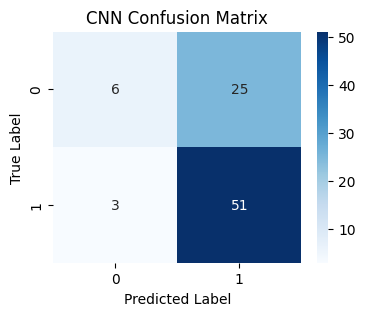

Best Random Forest 모델 성능:
정확도: 0.6353, F1: 0.7770, Recall: 1.0000, Precision: 0.6353, Specificity: 0.0000
Confusion Matrix:
[[ 0 31]
 [ 0 54]]


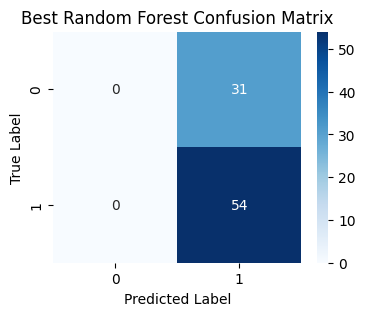

In [20]:
# 예측 실행 및 평가
predictions = {
    "Logistic Regression": predict_with_logistic_regression(X_synthetic, y_synthetic, X_test),
    "CART": predict_with_cart(X_synthetic, y_synthetic, X_test),
    "KNN": predict_with_knn(X_synthetic, y_synthetic, X_test),
    "XGBoost": predict_with_xgboost(X_synthetic, y_synthetic, X_test),
    "LSTM": predict_with_lstm(X_synthetic, y_synthetic, X_test),
    "CNN": predict_with_cnn(X_synthetic, y_synthetic, X_test),
    "Best Random Forest": predict_with_best_rf(X_test)
}

for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    precision = precision_score(y_test, pred_y)
    tn, fp, fn, tp = confusion_matrix(y_test, pred_y).ravel()
    specificity = tn / (tn + fp)
    conf_matrix = confusion_matrix(y_test, pred_y)

    print(f"{model_name} 모델 성능:")
    print(f"정확도: {accuracy:.4f}, F1: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
